# LLM Call


In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class MyGraphState(TypedDict):
    count: int
    msg: str

# Define my node
def counter(state: MyGraphState):
    state["count"] += 1
    state["msg"] = f"Counter dunc has been called {state['count']} time(s)."
    return state

workflow =StateGraph(MyGraphState)

workflow.add_node("Node1", counter)
workflow.add_node("Node2", counter)
workflow.add_node("Node3", counter)

workflow.add_edge(START, "Node1")
workflow.add_edge("Node1", "Node2")
workflow.add_edge("Node2", "Node3")
workflow.add_edge("Node3", END)


app = workflow.compile()

In [ ]:
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))

In [ ]:
app.invoke({"count":0, "msg":"Hello"})

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.1")

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}


builder =StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

input = {"messages": [HumanMessage("hi!")]}
for chunk in graph.stream(input):
    print(chunk)

# #2 Chain

In [23]:
from typing import Annotated,TypedDict

from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langgraph.graph import START,END, StateGraph

model_low_temp = ChatOllama(model="llama3.1", temperature=0.1)
model_high_temp = ChatOllama(model="llama3.1", temperature=0.7)

class State(TypedDict):
    messages : Annotated[list, add_messages]
    user_query : str
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str
    
class Output(TypedDict):
    sql_query:str
    sql_explanation:str

generate_prompt = SystemMessage(
    """You are a helpful data analyst who generates SQL queries for user based on their questions."""
)

def generate_sql(state:State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt,*state["messages"],user_message]
    res = model_low_temp.invoke(messages)
    return{
        "sql_query": res.content,
        "messages": [user_message, res]
    }

explain_prompt = SystemMessage(
    """You are a helpful data analyst whi explains SQL queries to users."""
)

def explain_sql(state:State) -> State:
    messages = [
        explain_prompt,
        *state["messages"]
    ]
    res = model_high_temp.invoke(messages)
    return{
        "sql_explanation":res.content,
        "messages": [res]

    }

In [24]:
builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql","explain_sql")
builder.add_edge("explain_sql", END)

graph =builder.compile()

/tmp/ipykernel_15282/1431255507.py:1: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)
/tmp/ipykernel_15282/1431255507.py:1: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)


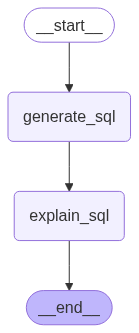

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
graph.invoke({"user_query": "What is the total sales for each product?"})

{'sql_query': 'Here\'s an SQL query that will give you the total sales for each product:\n\n```sql\nSELECT \n  product_name, \n  SUM(sales_amount) AS total_sales\nFROM \n  orders\nGROUP BY \n  product_name;\n```\n\nThis query works as follows:\n\n- `SELECT` selects the columns we want to see in our results. In this case, we\'re selecting the `product_name` and calculating the `total_sales` by summing up all sales amounts for each product.\n- `FROM orders` specifies that we\'re looking at data from the `orders` table.\n- `GROUP BY product_name` groups the rows of the result set by the `product_name`, so we can calculate the total sales for each product.\n\nNote: This assumes you have a table named "orders" with columns named "product_name" and "sales_amount". If your column names are different, you\'ll need to adjust the query accordingly.',
 'sql_explanation': ''}

# #3:Router

In [1]:
from typing import Annotated, TypedDict, Literal
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_ollama import ChatOllama, OllamaEmbeddings

from langgraph.graph import END,START, StateGraph
from langgraph.graph.message import add_messages

embedding = OllamaEmbeddings(model="llama3.1")
model_low_temp = ChatOllama(model="llama3.1", temperature=0.1)
model_high_temp = ChatOllama(model="llama3.1", temperature=0.7)

class State(TypedDict):
    messages : Annotated[list, add_messages]
    user_query: str
    domain: Literal["records", "insurance"]
    documents: list[Document]
    answer: str
class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    documents: list[Document]
    answer: str

# Initialize vector stores
medical_records_store = InMemoryVectorStore.from_documents(sample_docs, embeddings)
medical_records_retriever = medical_records_store.as_retriever()

insurance_faqs_store = InMemoryVectorStore.from_documents(sample_docs, embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

router_prompt = SystemMessage(
    """You need to decide which domain to route the user query to. You have two domains to choose from:
- records: contains medical records of the patient, such as diagnosis, treatment, and prescriptions.
- insurance: contains frequently asked questions about insurance policies, claims, and coverage.

Output only the domain name."""
)

NameError: name 'sample_docs' is not defined